#Package Setup

## Installations

In [16]:
!pip3 install umap-learn
!pip3 install sentence-transformers
!pip3 install pyvis

## Imports

In [17]:
import sys
print(sys.executable)


/opt/homebrew/opt/python@3.14/bin/python3.14


In [18]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install umap-learn scikit-learn scipy sentence-transformers matplotlib pyvis pandas numpy seaborn branca


  Using cached pip-26.0.1-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-26.0.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.3
error: uninstall-no-record-file

× Cannot uninstall pip 25.3
╰─> The package's contents are unknown: no RECORD file was found for pip.

hint: The package was installed by brew. You should check if it can uninstall the package.


In [19]:
import csv
import umap
from scipy import spatial
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from collections import defaultdict
import pyvis
from pyvis.network import Network
import numpy as np
import seaborn as sns
import branca.colormap as cm
import branca
import pandas as pd
import re
from textwrap import wrap
import json

project_path = ""

# Visualization Creation Process

## Create Embeddings from Raw Data

In [5]:
# Read attendees and their responses from a CSV file, replace attendees.csv with own link or file name
attendees_map = {}
with open(project_path+ 'classmates.csv', newline='') as csvfile:
    attendees = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(attendees)  # Skip the header row
    for row in attendees:
        name, paragraph = row
        attendees_map[paragraph] = name

# Generate sentence embeddings
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
paragraphs = list(attendees_map.keys())
embeddings = model.encode(paragraphs)

# Create a dictionary to store embeddings for each person
person_embeddings = {attendees_map[paragraph]: embedding for paragraph, embedding in zip(paragraphs, embeddings)}


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2297.15it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [20]:
print("People loaded:", len(attendees_map))
print("First 2 entries:", list(attendees_map.items())[:2])

print("Paragraphs:", len(paragraphs))
print("Embeddings shape:", np.array(embeddings).shape)


People loaded: 18
First 2 entries: [('Swim, bike, run', 'Greg Kirczenow'), ('I like hiking, swimming, traveling, enjoying nice weather and sun, and spending time with my family', 'Nikita Neveditsin')]
Paragraphs: 18
Embeddings shape: (18, 384)


## Reducing dimensionality of embedding data, scaling to coordinate domain/range


In [21]:
# Reducing dimensionality of embedding data, scaling to coordinate domain/range
reducer = umap.UMAP(random_state=42)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(list(person_embeddings.values()))
reduced_data = reducer.fit_transform(scaled_data)


/opt/homebrew/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [22]:
print("Reduced shape:", reduced_data.shape)
print("First 5 points:\n", reduced_data[:5])


Reduced shape: (18, 2)
First 5 points:
 [[ -6.3922105 -12.197358 ]
 [ -7.7993226 -12.400179 ]
 [ -6.9968996 -12.1191   ]
 [ -7.2249784 -12.604629 ]
 [ -6.410314  -11.462164 ]]


## Create Visualization Image

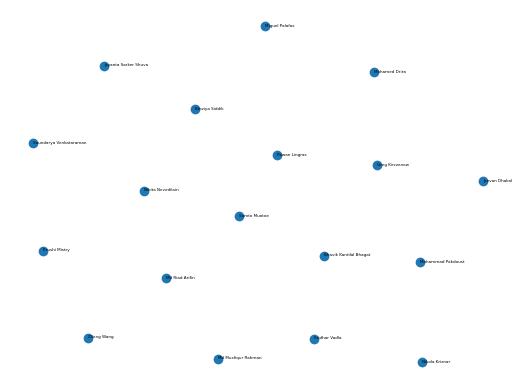

In [23]:
# Creating lists of coordinates with accompanying labels
x = [row[0] for row in reduced_data]
y = [row[1] for row in reduced_data]
label = list(person_embeddings.keys())

# Plotting and annotating data points
plt.scatter(x,y)
for i, name in enumerate(label):
    plt.annotate(name, (x[i], y[i]), fontsize="3")

# Clean-up and Export
plt.axis('off')
plt.savefig(project_path+'sample.png', dpi=800)

## Find the  top N matches to a node

In [27]:
missing = [p for p in set(attendees_map.values()) if p not in person_embeddings]
print("missing in person_embeddings:", missing)
print("person_embeddings count:", len(person_embeddings))


missing in person_embeddings: []
person_embeddings count: 18


In [28]:
import numpy as np

nan_count = 0
for person in attendees_map.values():
    for d, target in all_personal_pairs[person]:
        if np.isnan(d):
            nan_count += 1
print("NaN distances:", nan_count)


NaN distances: 0


In [29]:
# Providing top matches
top_matches = {}
all_personal_pairs = defaultdict(list)
for person in attendees_map.values():
    for person1 in attendees_map.values():
       dist = float(spatial.distance.cosine(person_embeddings[person1], person_embeddings[person]))
all_personal_pairs[person].append([dist, person1])

print("Example person:", list(attendees_map.values())[0])
print("Pairs for example:", len(all_personal_pairs[list(attendees_map.values())[0]]))


n = 5
# Collect the top n most similarity nodes
data_day_list = []
for person in attendees_map.values():
    top_matches[person] = sorted(all_personal_pairs[person], key=lambda x: x[0])[1:n+1] # drop yourself, take top 5
    a = sorted(all_personal_pairs[person], key=lambda x: x[0])[1:n+1]
    mini_df = pd.DataFrame(a, columns=['Weight', 'Target'])
    mini_df['Source'] = person
    data_day_list.append(mini_df)

# output this information as a json
with open(project_path + 'b_top5_matches.json', 'w') as json_file:
    json.dump(top_matches, json_file, indent=2)

# Output this information as a csv
df = pd.concat(data_day_list)
df.to_csv(project_path + 'b_top5_matches.csv', index=False)


Example person: Greg Kirczenow
Pairs for example: 0


## Add Colour/Paragraph Information to Dataframe

In [ ]:
# Get the colour pallette
colour = sns.color_palette("pastel",len(x)).as_hex()

# Add colour pallette to the df
df1 = pd.DataFrame([label,colour])
df1 = df1.T
df1.rename(columns={0: 'Source', 1: 'Colour'},inplace=True)
df = df.set_index('Source').join(df1.set_index('Source'))
df['Source'] = df.index
df = df.reset_index(drop=True)

# Add colour pallette for both the df Target and Source:
df1.rename(columns={'Source': 'Target'},inplace=True)
df = df.set_index('Target').join(df1.set_index('Target'),lsuffix='_Source', rsuffix='_Target')
df['Target'] = df.index
df = df.reset_index(drop=True)
print(df)

# Add paragraphs to the df
df2 = pd.DataFrame([label,paragraphs])
df2 = df2.T
df2.rename(columns={0: 'Source', 1: 'Paragraphs'},inplace=True)
df = df.set_index('Source').join(df2.set_index('Source'))
df['Source'] = df.index
df = df.reset_index(drop=True)
print(df)

# Create a cleaned Dataframe of just the Source and and Paragraph information
df_new = df[["Source","Paragraphs"]]
df_new = df_new.drop_duplicates()
df_new.set_index('Source', inplace=True)

## Build Interative Network Visualization (Simple)

In [ ]:
# Intitalize bucket size and colour palettes
buckets = [100] * len(x)
colour = sns.color_palette("pastel",len(x)).as_hex()

# Initialize network
g = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

# Add unconnected nodes to the network
g.add_nodes(list(range(1,len(x)+1)), value=buckets,
                         title=paragraphs,
                         x=np.array(x).astype(np.float64),
                         y=np.array(y).astype(np.float64),
                         label=label,
                         color=colour)

# Output the visualization
g.toggle_physics(True)
g.show(project_path+'c_simple_viz.html', notebook=False)

## Build Interative Network Visualization (Complex)


In [ ]:
# Initialize network
got_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white",select_menu=True,cdn_resources='remote')

# Create a dictionary of Important information
sources = df['Source']
targets = df['Target']
weights = df['Weight']
color_targets = df['Colour_Target']
color_sources = df['Colour_Source']

edge_data = zip(sources, targets, weights,color_targets,color_sources)

# Add nodes and edges to the network
for e in edge_data:
                src = e[0]
                dst = e[1]
                w = e[2]
                c_t= e[3]
                c_s= e[4]
                got_net.add_node(src, src, title=src,color=c_s)
                got_net.add_node(dst, dst, title=dst)
                got_net.add_edge(src, dst, value=w)#,color = "#c79910") # if you  want a solide colour for edges

# Add paragraphs to the popup
for i,node in enumerate(got_net.nodes):
               content =df_new.loc[node.get("title"),"Paragraphs"]
               node["title"] += ": "+ "\n \n" +'\n'.join(wrap(content, width=50))

## Output the visualization
got_net.show(project_path+'c_complex_viz.html', notebook=False)